 # Data Challenge Workshop: Classification of business-related News Articles

In [67]:
from numpy.random import seed
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.grid_search import GridSearchCV

In [68]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

#### Ensure reproducability

In [69]:
seed(1)

### A) Data Exploration

In [70]:
df=pd.read_csv('jacobs_corpus_body_labeled.csv')

In [71]:
df.shape

(497, 16)

#### Understand your data

In [72]:
df.head(2)

,date,file_id,text,title,labels,-1,Profit,Dividend,MergerAcquisition,SalesVolume,BuyRating,QuarterlyResults,TargetPrice,ShareRepurchase,Turnover,Debt
0,22-11-2005,1,Absa reports solid growth with Barclays in con...,absa reports solid growth with barclays in con...,"['MergerAcquisition', 'MergerAcquisition', 'Sa...",0,1,1,1,1,0,0,0,0,0,0
1,2-10-2013,3,Aggreko falls to two-year low following Unilev...,aggreko falls to two-year low following unilev...,"['BuyRating', 'Profit', 'BuyRating', 'Profit']",0,1,0,0,0,1,0,0,0,0,0


In [73]:
multi_labels = ['-1',
       'Profit', 'Dividend', 'MergerAcquisition', 'SalesVolume', 'BuyRating',
       'QuarterlyResults', 'TargetPrice', 'ShareRepurchase', 'Turnover',
       'Debt']

In [74]:
df[multi_labels].apply(pd.Series.value_counts)

,-1,Profit,Dividend,MergerAcquisition,SalesVolume,BuyRating,QuarterlyResults,TargetPrice,ShareRepurchase,Turnover,Debt
0,441,217,386,357,311,399,347,438,450,376,446
1,56,280,111,140,186,98,150,59,47,121,51


In [75]:
X = df['text']

In [76]:
y = df['MergerAcquisition']

####  Data set not balanced!

In [77]:
X.shape,y.shape

((497,), (497,))

#### Split in training and test set

In [78]:
X_train, X_test, y_train, y_test,df_train,df_test = train_test_split(X, y, df,test_size=0.33, random_state=42)

### B) Designing features

In [79]:
def tokenizer(text):
    tokens = text.split(' ')
    return tokens

In [80]:
tfidf = TfidfVectorizer(tokenizer=tokenizer,ngram_range=(1,3),analyzer='word',max_features=1000)

In [81]:
X_train_bow = tfidf.fit_transform(X_train)

In [82]:
X_train_bow.shape

(332, 1000)

In [83]:
feature_names = np.array(tfidf.get_feature_names())

In [84]:
feature_names[:10]

array(['', ' "', ' the', '"', '" ,', '" .', '" buy', '" buy "', '" he',
       '" he said'], dtype='<U22')

Careful, high-dimensional data! Feature dimension p larger than number of data points n: linear modeles are prefered

### C) Model Training 

\begin{align*}
&\hat{y} = w[0] x[0] + w[1] x[1] + \dotsc + w[p] * x[p] + b > 0 &\text{weights w$_i$}
\end{align*}

In [85]:
lr = LogisticRegression(penalty='l2',C=1.0)

In [86]:
lr_model = lr.fit(X_train_bow, y_train)

Check performance on training set!

### D) Model Evaluation

#### Check performance on independent test set

In [87]:
X_test_bow = tfidf.transform(X_test)

In [88]:
y_test_pred_lin = lr_model.predict(X_test_bow)

In [89]:
print(classification_report(y_test,y_test_pred_lin,target_names=['No Merger','Merger&Acquisitions']))

                     precision    recall  f1-score   support

          No Merger       0.69      0.99      0.81       113
Merger&Acquisitions       0.67      0.04      0.07        52

        avg / total       0.68      0.69      0.58       165



In [90]:
precision_recall_fscore_support(y_test,y_test_pred_lin)

(array([0.69135802, 0.66666667]),
 array([0.99115044, 0.03846154]),
 array([0.81454545, 0.07272727]),
 array([113,  52]))

#### Understand your model weights

Text(0, 0.5, 'weights w$_i$')

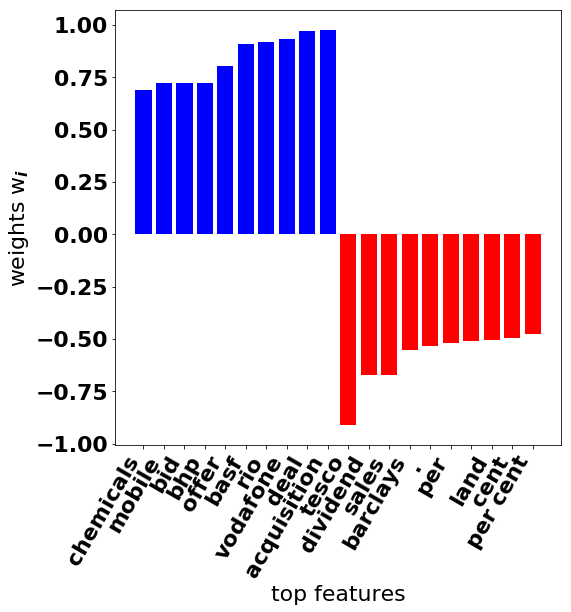

In [91]:
plt.figure(figsize=[8,8])
ax=plt.gca()
top_features=10
coef = lr_model.coef_[0,:].flatten()
class1_coef = np.argsort(coef)[-top_features:]
class2_coef = np.argsort(coef)[:top_features]
combine_coef = np.hstack([class1_coef,class2_coef])
colors = ['red' if c<0 else 'blue' for c in coef[combine_coef]]
plt.bar(np.arange(len(combine_coef)),coef[combine_coef],color=colors)
ax.set_xticks(np.arange(len(combine_coef)))
tmp=ax.set_xticklabels(feature_names[combine_coef],rotation=60,ha='right')
plt.xlabel('top features')
plt.ylabel('weights w$_i$')

### 5-Fold Cross validation

In [95]:
from sklearn.model_selection import StratifiedKFold

In [98]:
def cross_validation(X,y):
    '''
    K-fold cross validation 
    '''
    
    kf = StratifiedKFold(n_splits=4,random_state=42)

    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train_bow = tfidf.fit_transform(X_train)

        lr = LogisticRegression(penalty='l2',C=1.0)
        lr_model = lr.fit(X_train_bow, y_train)

        X_test_bow = tfidf.transform(X_test)
        y_test_pred_lin = lr_model.predict(X_test_bow)
        precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_test_pred_lin)
        print(precision, recall, fscore, support)

In [99]:
cross_validation(X,y)

[0.72727273 0.5       ] [0.97777778 0.05714286] [0.83412322 0.1025641 ] [90 35]
[0.71544715 0.        ] [0.98876404 0.        ] [0.83018868 0.        ] [89 35]
[0.72357724 1.        ] [1.         0.02857143] [0.83962264 0.05555556] [89 35]
[0.71544715 0.        ] [0.98876404 0.        ] [0.83018868 0.        ] [89 35]


Large variation during cross validation!

### Hyperparameter search

In [104]:
# not fully implemented
#parameters = {'C': [0.1, 1, 10, 100]}
# grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)
# grid.fit(X_train,y_train)
# grid.best_params_

### Explore more sophisticated classifiers, e.g. support vector machines

In [105]:
from sklearn.svm import LinearSVC

In [108]:
svc = LinearSVC()

In [109]:
svc_model =  svc.fit(X_train_bow,y_train)

In [110]:
y_test_pred_svc = svc_model.predict(X_test_bow)

In [111]:
print(classification_report(y_test,y_test_pred_lin,target_names=['No Merger','Merger&Acquisitions']))

                     precision    recall  f1-score   support

          No Merger       0.69      0.99      0.81       113
Merger&Acquisitions       0.67      0.04      0.07        52

        avg / total       0.68      0.69      0.58       165



Text(0, 0.5, 'weights w$_i$')

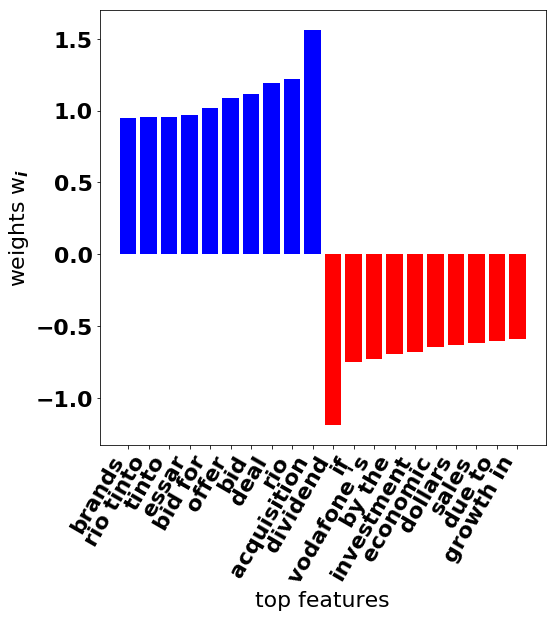

In [112]:
plt.figure(figsize=[8,8])
ax=plt.gca()
top_features=10
coef = svc_model.coef_[0,:].flatten()
class1_coef = np.argsort(coef)[-top_features:]
class2_coef = np.argsort(coef)[:top_features]
combine_coef = np.hstack([class1_coef,class2_coef])
colors = ['red' if c<0 else 'blue' for c in coef[combine_coef]]
plt.bar(np.arange(len(combine_coef)),coef[combine_coef],color=colors)
ax.set_xticks(np.arange(len(combine_coef)))
tmp=ax.set_xticklabels(feature_names[combine_coef],rotation=60,ha='right')
plt.xlabel('top features')
plt.ylabel('weights w$_i$')